# Preprocessing the data to fit ConvLSTMs
The goal here is to convert this data to a suitable format that can be used as a channel input for the ConvLSTM.

## Interlude: picking longitude and latitude on HRRR doesn't work
But first, an interlude. Surely we can just use latitude and longitude in order to pick the exact areas that we want to subset, right...?

No. HRRR data uses a *curvilinear grid*, a result of Lambert-conformal conical projection. We're used to using a classic Cartesian coordinate system, using the geodetic coordinate system (latitude, longitude, etc.), on an equirectanfular projection (aka plate carree). This is what is used in the PWWB repo.
- Parameters of the LCC projection used by HRRR: https://ntrs.nasa.gov/api/citations/20160009371/downloads/20160009371.pdf
- Herbie discussion on HRRR, Cartesian coordinates, and curvilinear grids: https://github.com/blaylockbk/Herbie/discussions/45

In short, we can't use classic longitude and latitude units. Selecting points on a curvilinear grid based on longitude and latitude will require some preprocessing.
- Using Herbie to pick points on HRRR datasets: https://herbie.readthedocs.io/en/2024.5.0/user_guide/tutorial/accessor_notebooks/pick_points.html#Pick-points-from-HRRR-data

## Example: Palisades fire
Now that we know how to picking longitude/latitude points on a curvilinear grid, let's do it to subset our data.

### Grabbing data

In [1]:
from herbie import Herbie
import numpy as np

# pull data, place into xarray
H = Herbie(
    "2025-01-10",
    model="hrrr",
    product="sfc",
    fxx=0,
)

# examine xarray data
ds = H.xarray("MASSDEN")
ds

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/mgraca/Workspace/hrrr-smoke-viz/venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


<xarray.Dataset> Size: 38MB
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2025-01-10
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 8.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B 2025-01-10
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    mdens                (y, x) float32 8MB 1.52e-09 1.52e-09 ... 8.855e-26
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/mgraca/data/hrrr/20250110/subset_d9ef9dd4_...
    search:                  MASSDEN

In [2]:
# coerce to numpy
ds_np = ds['mdens'].to_numpy()
ds_np

array([[1.52000e-09, 1.52000e-09, 1.52000e-09, ..., 8.85486e-26,
        8.85486e-26, 8.85486e-26],
       [1.52000e-09, 1.52000e-09, 1.52000e-09, ..., 8.85486e-26,
        8.85486e-26, 8.85486e-26],
       [1.60000e-09, 1.60000e-09, 1.60000e-09, ..., 8.85486e-26,
        8.85486e-26, 8.85486e-26],
       ...,
       [8.85486e-26, 8.85486e-26, 8.85486e-26, ..., 8.85486e-26,
        8.85486e-26, 8.85486e-26],
       [8.85486e-26, 8.85486e-26, 8.85486e-26, ..., 8.85486e-26,
        8.85486e-26, 8.85486e-26],
       [8.85486e-26, 8.85486e-26, 8.85486e-26, ..., 8.85486e-26,
        8.85486e-26, 8.85486e-26]], shape=(1059, 1799), dtype=float32)

The goal is to get a subset of this data; not the whole 1060 x 1800 grid. To do that, we need a way to index the specific longitude and latitude boundaries to susbet the data.

### Plot function

In [3]:
import matplotlib.pyplot as plt
from herbie.toolbox import EasyMap, pc, ccrs
from herbie import paint

def plot(ds, coords=None, save=False, transform=pc):
    plt.figure()
    ax = EasyMap("50m", crs=transform, figsize=[10, 8]).BORDERS().STATES().ax
    
    if coords != None:
        ax.set_extent(coords)
    
    p = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.mdens * micro_per_k,
        transform=pc,
        **paint.AQIPm25.kwargs2,
    )
    plt.colorbar(
        p,
        ax=ax,
        orientation="horizontal",
        pad=0.01,
        shrink=0.8,
        **paint.AQIPm25.kwargs2,
    )
    
    ax.set_title(
        f"{ds.model.upper()}: {H.product_description}\nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
        loc="left",
    )
    ax.set_title(ds.mdens.GRIB_name, loc="right")

    if save:
        plt.savefig(f"images/hrrr_viz_{str(int(ds.step.item() / 3600000000000)).zfill(2)}.png")
        
    plt.show()
    plt.clf()

### Attempt 1; using metpy
Using metpy with xarray to manage coordinate systems: https://unidata.github.io/MetPy/v0.9/tutorials/xarray_tutorial.html

https://stackoverflow.com/a/54245119

In [4]:
'''
# parse the dataset for projection and coordinate information following the CF (climate forecast) conventions
parsed = ds.metpy.parse_cf()
display(parsed)

# examine crs data
ds_proj = parsed['mdens'].metpy.cartopy_crs
print(ds_proj)

# Declare bounding box
min_lat, max_lat = 33.28, 34.86
min_lon, max_lon = -119.1, -117.3
bounding_lat = [min_lat, max_lat]
bounding_lon = [min_lon, max_lon]

# By transposing the result of transform_points, we can unpack the
# x and y coordinates into individual arrays.
x_lim, y_lim, _ = ds_proj.transform_points(
    ccrs.PlateCarree(),
    np.array(bounding_lon), 
    np.array(bounding_lat)
).T

# produces values in meters? HRRR may be using different units
a, b = [int(i) for i in x_lim]
c, d = [int(i) for i in y_lim]
print(*x_lim, a, b)
print(*y_lim, c, d)

ds_subset = ds.sel(x=slice(a, b), y=slice(c, d))
ds_subset
'''

"\n# parse the dataset for projection and coordinate information following the CF (climate forecast) conventions\nparsed = ds.metpy.parse_cf()\ndisplay(parsed)\n\n# examine crs data\nds_proj = parsed['mdens'].metpy.cartopy_crs\nprint(ds_proj)\n\n# Declare bounding box\nmin_lat, max_lat = 33.28, 34.86\nmin_lon, max_lon = -119.1, -117.3\nbounding_lat = [min_lat, max_lat]\nbounding_lon = [min_lon, max_lon]\n\n# By transposing the result of transform_points, we can unpack the\n# x and y coordinates into individual arrays.\nx_lim, y_lim, _ = ds_proj.transform_points(\n    ccrs.PlateCarree(),\n    np.array(bounding_lon), \n    np.array(bounding_lat)\n).T\n\n# produces values in meters? HRRR may be using different units\na, b = [int(i) for i in x_lim]\nc, d = [int(i) for i in y_lim]\nprint(*x_lim, a, b)\nprint(*y_lim, c, d)\n\nds_subset = ds.sel(x=slice(a, b), y=slice(c, d))\nds_subset\n"

Abandoning this, because herbie should be sufficient; it uses metpy and pygrib in the back end.

### Attempt 2; using Zarr documentation
https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/ex_python_plot_zarr.html

In [5]:
'''
# same as ds.metpy.parse_cf and ds.herbie.crs
projection = ccrs.LambertConformal(
    central_longitude=262.5,
    central_latitude=38.5,
    standard_parallels=(38.5, 38.5),
    globe=ccrs.Globe(semimajor_axis=6371229, semiminor_axis=6371229)
)

lat, lon = 34.0, -118.24
x, y = projection.transform_point(lon, lat, ccrs.PlateCarree())
print(x, y)
'''

'\n# same as ds.metpy.parse_cf and ds.herbie.crs\nprojection = ccrs.LambertConformal(\n    central_longitude=262.5,\n    central_latitude=38.5,\n    standard_parallels=(38.5, 38.5),\n    globe=ccrs.Globe(semimajor_axis=6371229, semiminor_axis=6371229)\n)\n\nlat, lon = 34.0, -118.24\nx, y = projection.transform_point(lon, lat, ccrs.PlateCarree())\nprint(x, y)\n'

### Attempt 3; subsetting using longitude skew, and `where()`
- "Use Case 4: Small region of grid, multiple model runs": https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/python_data_loading.html

In [6]:
lat_bottom, lat_top = 33.28, 34.86
lon_bottom, lon_top = -119.1 + 360, -117.3 + 360 # why long is offset by 360, i have no idea

def check_boundaries(data):
    lat_in_range = (lat_bottom < data.latitude) & (data.latitude < lat_top)
    lon_in_range = (lon_bottom < data.longitude) & (data.longitude < lon_top)
    return (lat_in_range & lon_in_range).compute()

sub_ds = ds.where(check_boundaries, drop=True)
sub_ds

<xarray.Dataset> Size: 92kB
Dimensions:              (y: 69, x: 67)
Coordinates:
    time                 datetime64[ns] 8B 2025-01-10
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 8.0
    latitude             (y, x) float64 37kB 32.97 32.98 32.99 ... 35.15 35.15
    longitude            (y, x) float64 37kB 241.0 241.0 241.1 ... 242.6 242.6
    valid_time           datetime64[ns] 8B 2025-01-10
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    mdens                (y, x) float32 18kB nan nan nan nan ... nan nan nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/mgraca/data/hrrr/20250110/subset_d9ef9dd4_...
    search:                  MASSDEN

"Note that while we've dropped rows and columns with no datapoints in the box, we still have lots of null datapoints where either the projection x or the projection y coordinate is sometimes within the box, but the combination is not."

In other words, we have a lot of NaNs because BOTH x and y may not be in the box, even if one of them are.

Playing with transforms: 
- https://herbie.readthedocs.io/en/2024.5.0/user_guide/tutorial/bonus_notebooks/demo_map.html
- https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html

I don't know why `transform=pc` is there by default, but if you want to play around with different systems, you change `crs` on `EasyMap`.

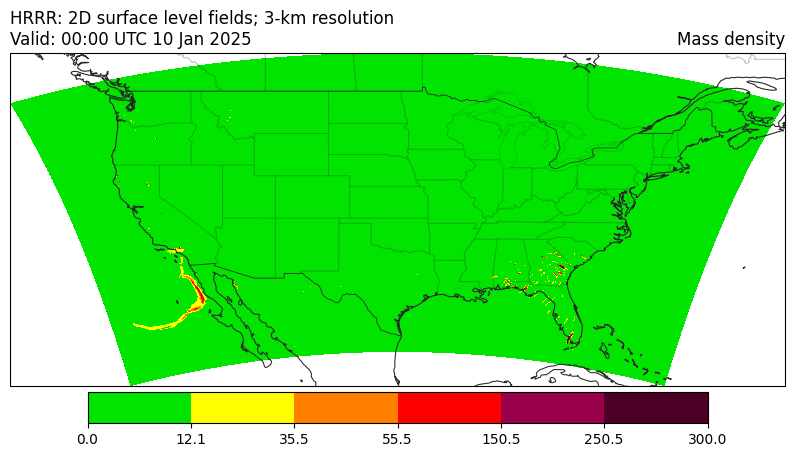

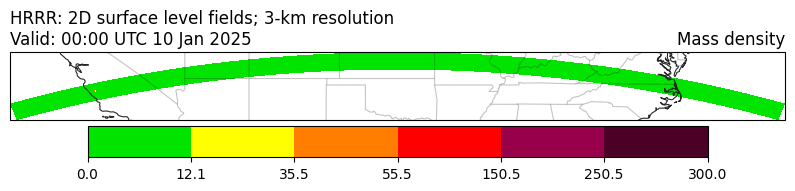

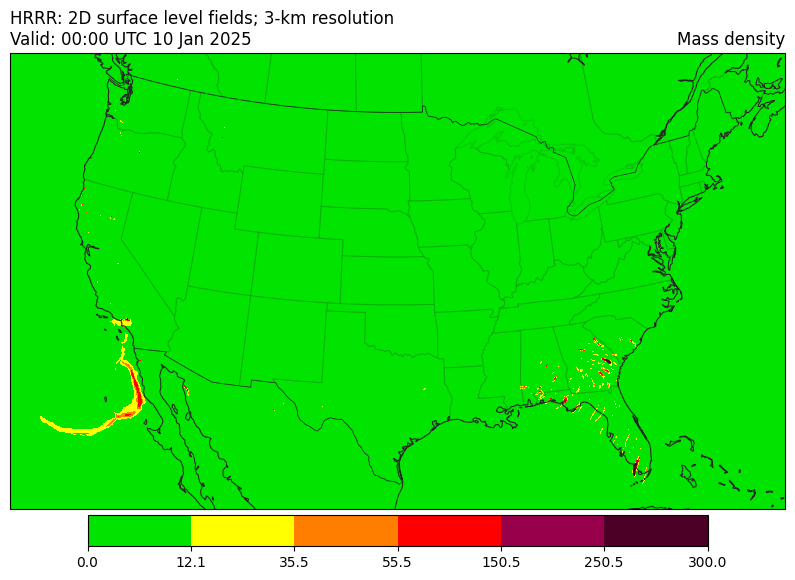

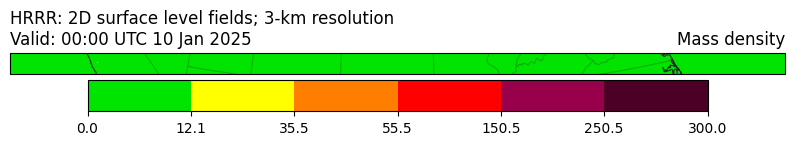

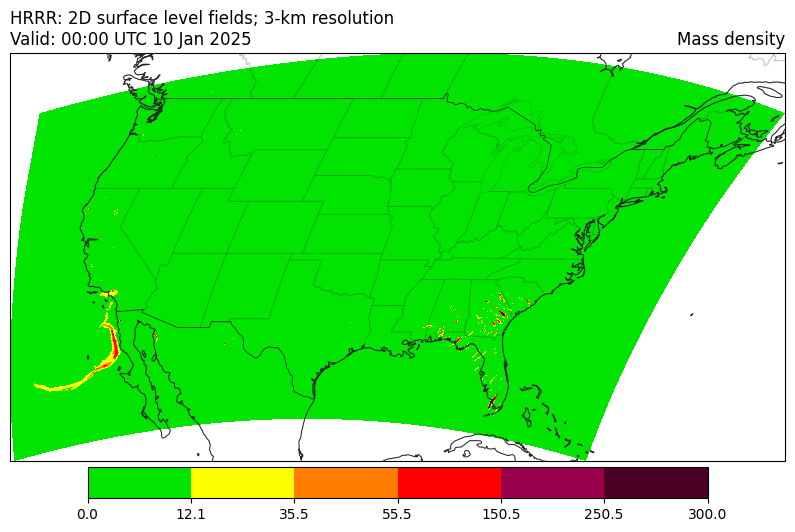

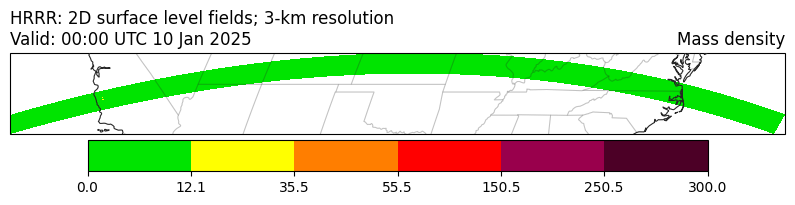

<Figure size 640x480 with 0 Axes>

In [7]:
micro_per_k = 1000000000
'''
moderate_quality = 12.1
ds["mdens"] = ds.mdens.where(ds.mdens * micro_per_k > moderate_quality - 10)
display(ds.mdens)
'''

'''
# this is the same as `ds.herbie.crs`, use that instead
lc=ccrs.LambertConformal(
    central_longitude=262.5,
    central_latitude=38.5,
    standard_parallels=(38.5, 38.5),
    globe=ccrs.Globe(semimajor_axis=6371229, semiminor_axis=6371229)
)
'''

# plot: 
plot(ds) # lcp to plate carree
plot(ds.isel(y=slice(500,550)))

plot(ds, transform=ds.herbie.crs) # lambert conformal
plot(ds.isel(y=slice(500,550)), transform=ds.herbie.crs)

plot(ds, transform=ccrs.Robinson()) # lcp to robinson
plot(ds.isel(y=slice(500,550)), transform=ccrs.Robinson())

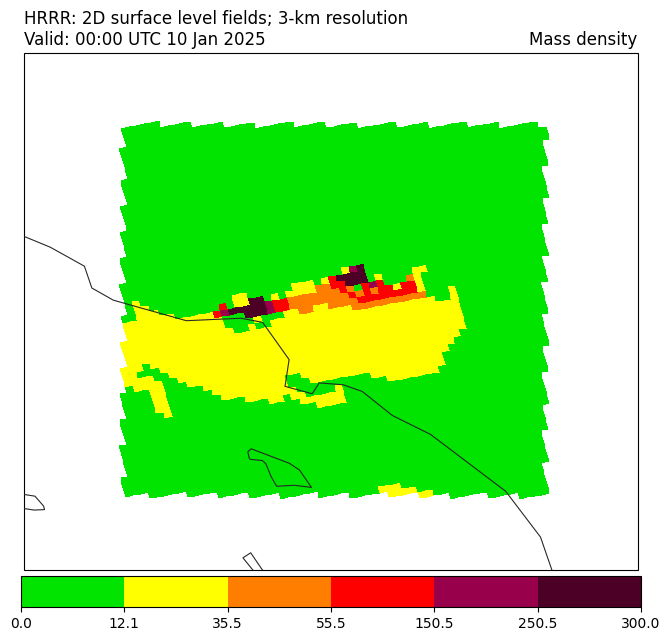

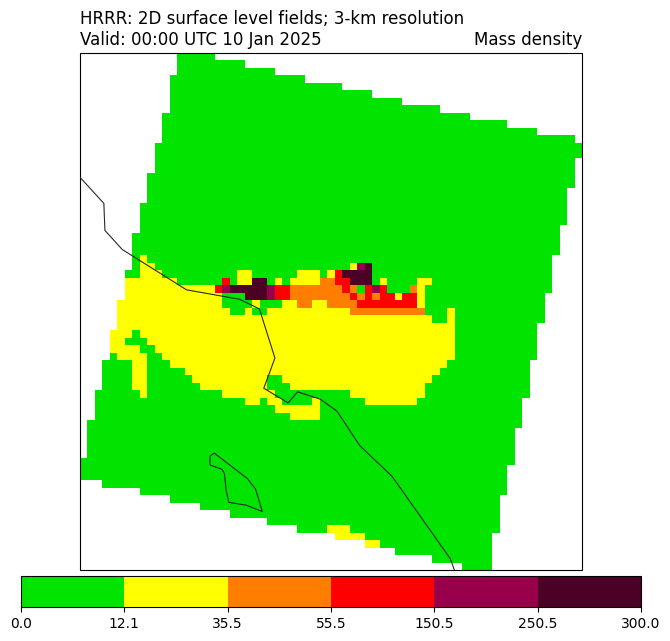

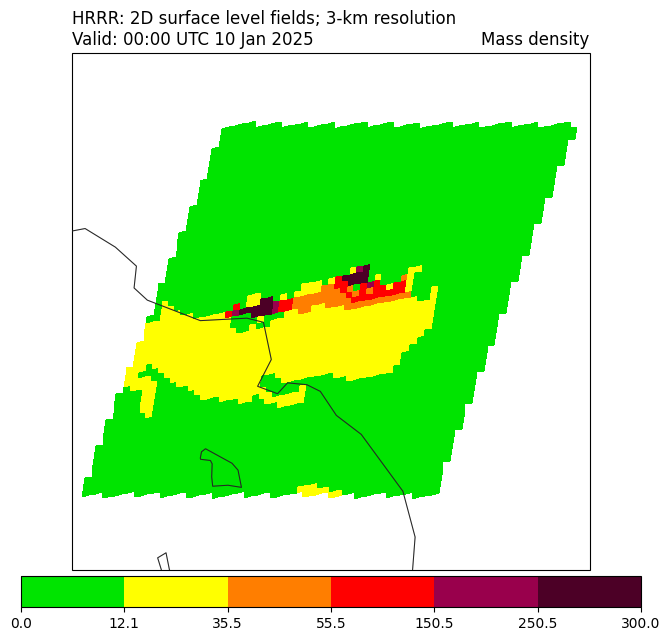

<Figure size 640x480 with 0 Axes>

In [8]:
plot(sub_ds, transform=pc)
plot(sub_ds, transform=sub_ds.herbie.crs) # is skew b/c subregion uses lon/lat instead of lcp coords??
plot(sub_ds, transform=ccrs.Robinson()) # looks like pwwb, which uses robinson->pc as well; just not sure what exact lat/lon they use

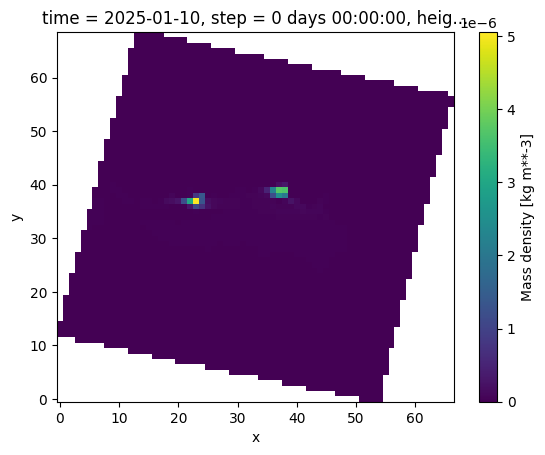

In [9]:
sub_ds.mdens.plot()

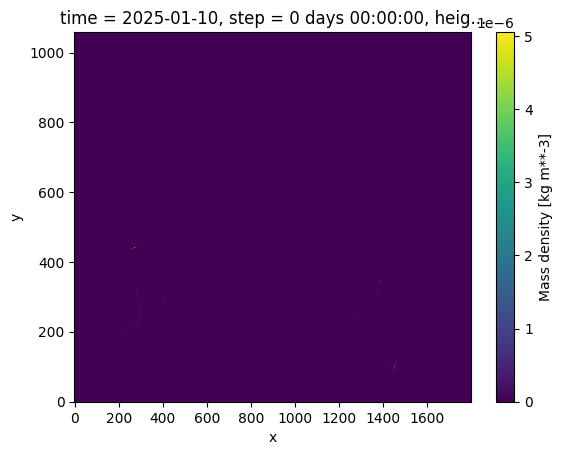

In [10]:
ds.mdens.plot()

In [11]:
# coerce to numpy
ds_np = sub_ds['mdens'].to_numpy()
ds_np

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(69, 67), dtype=float32)